# Age of Empires II Match Analysis

This notebook analyzes match data from Age of Empires II to discover patterns in game outcomes based on civilizations, map types, match duration, and player positions.

The dataset contains information about matches including:
- Match details (ID, map, duration)
- Player civilizations
- Player starting positions
- ELO ratings
- Match outcomes

We'll explore how these factors influence win rates and identify patterns to help players make better strategic choices.

In [26]:
# Let's do some clustering to find patterns
# Player position analysis - create heatmap of starting positions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# load the data
df = pd.read_csv('aoe_data.csv')
data = df.copy()

# drop match uid -- not needed for analysis
df = df.drop(columns=['Unnamed: 0'])

## Data Preparation

Above, we import necessary libraries and load the AOE2 match dataset. We've removed unnecessary columns to focus on the relevant match information.

In [27]:
# Create a dataframe for civilization win rates by game duration for clustering
# Group by civilization and game duration category
df['duration_category'] = pd.cut(df['duration'], bins=[0, 1500, 2500, 3500, 7000], labels=['Early', 'Mid', 'Late', 'Very Late'])

# Creating a pivot table for civilization win rates across different game durations
# Fix warnings by setting observed=True
p1_civs = df.groupby(['p1_civ', 'duration_category'], observed=True).agg({'winner': lambda x: sum(x == 1)/len(x) * 100 if len(x) > 0 else 50}).reset_index()
p2_civs = df.groupby(['p2_civ', 'duration_category'], observed=True).agg({'winner': lambda x: sum(x == 2)/len(x) * 100 if len(x) > 0 else 50}).reset_index()

# Rename columns for clarity
p1_civs.columns = ['civilization', 'duration_category', 'win_rate']
p2_civs.columns = ['civilization', 'duration_category', 'win_rate']

# Combine both datasets
all_civs = pd.concat([p1_civs, p2_civs])

# Average win rates by civilization and duration using observed=True to suppress warnings
civ_win_rates = all_civs.groupby(['civilization', 'duration_category'], observed=True)['win_rate'].mean().reset_index()

# Create a pivot table for clustering
heatmap_df = civ_win_rates.pivot(index='civilization', columns='duration_category', values='win_rate')

# Display the data
print(f"We have win rate data for {len(heatmap_df)} civilizations across different game durations")
heatmap_df.sort_values('Very Late', ascending=False).head(2)

We have win rate data for 39 civilizations across different game durations


duration_category,Early,Mid,Late,Very Late
civilization,,,,
Burmese,27.453271,25.129870,29.938272,28.767123
Incas,24.804178,27.210611,24.180735,28.267477


## Civilization Performance by Game Duration

Different civilizations have distinct strengths that manifest at different stages of the game. For example:

- **Early Game** specialists typically have strong economic bonuses or rushing capabilities
- **Mid Game** specialists often excel with unique units or Castle Age power spikes
- **Late Game** specialists typically have powerful unique units or imperial age technologies
- **Very Late Game** specialists usually have strong trash units or resource efficiency

The analysis above categorizes game duration into four distinct phases and calculates win rates for each civilization across these phases.

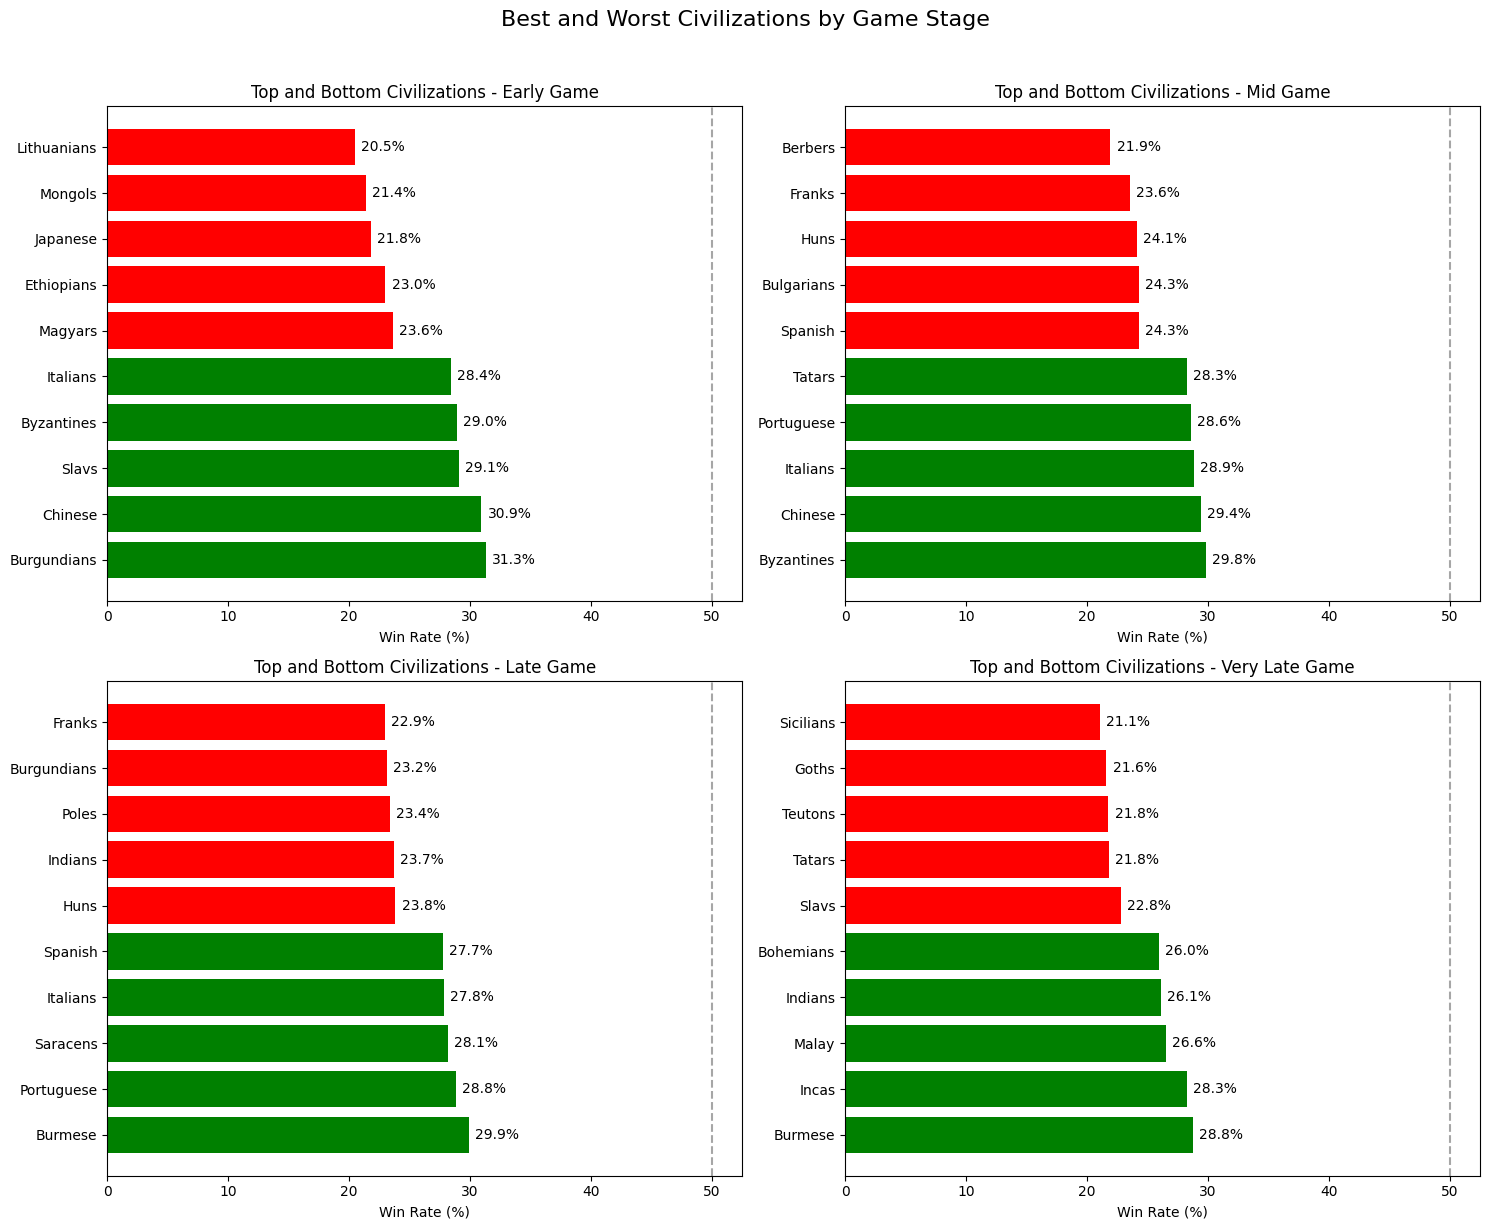

In [28]:
# Create a visualization that shows top and bottom performers for each game stage
plt.figure(figsize=(15, 12))

# For each game stage
for i, stage in enumerate(['Early', 'Mid', 'Late', 'Very Late']):
    plt.subplot(2, 2, i+1)
    
    # Sort the data
    stage_data = heatmap_df[stage].sort_values(ascending=False).dropna()
    
    # Get top and bottom 5
    top_5 = stage_data.head(5)
    bottom_5 = stage_data.tail(5)
    
    # Combine them
    plot_data = pd.concat([top_5, bottom_5])
    
    # Create a color map (green for top, red for bottom)
    colors = ['green']*5 + ['red']*5
    
    # Plot horizontal bar chart
    bars = plt.barh(plot_data.index, plot_data.values, color=colors)
    
    # Add a vertical line at 50% (theoretical balanced win rate)
    plt.axvline(x=50, color='gray', linestyle='--', alpha=0.7)
    
    # Add value labels to the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center')
    
    plt.title(f'Top and Bottom Civilizations - {stage} Game')
    plt.xlabel('Win Rate (%)')
    plt.tight_layout()

plt.suptitle('Best and Worst Civilizations by Game Stage', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## Civilization Clustering Analysis

By applying machine learning techniques like K-means clustering, we can identify groups of civilizations that exhibit similar performance patterns across different game stages. This clustering helps us understand which civilizations share strategic strengths and weaknesses.

The code below applies K-means clustering to group civilizations based on their win rates across early, mid, late, and very late game phases.

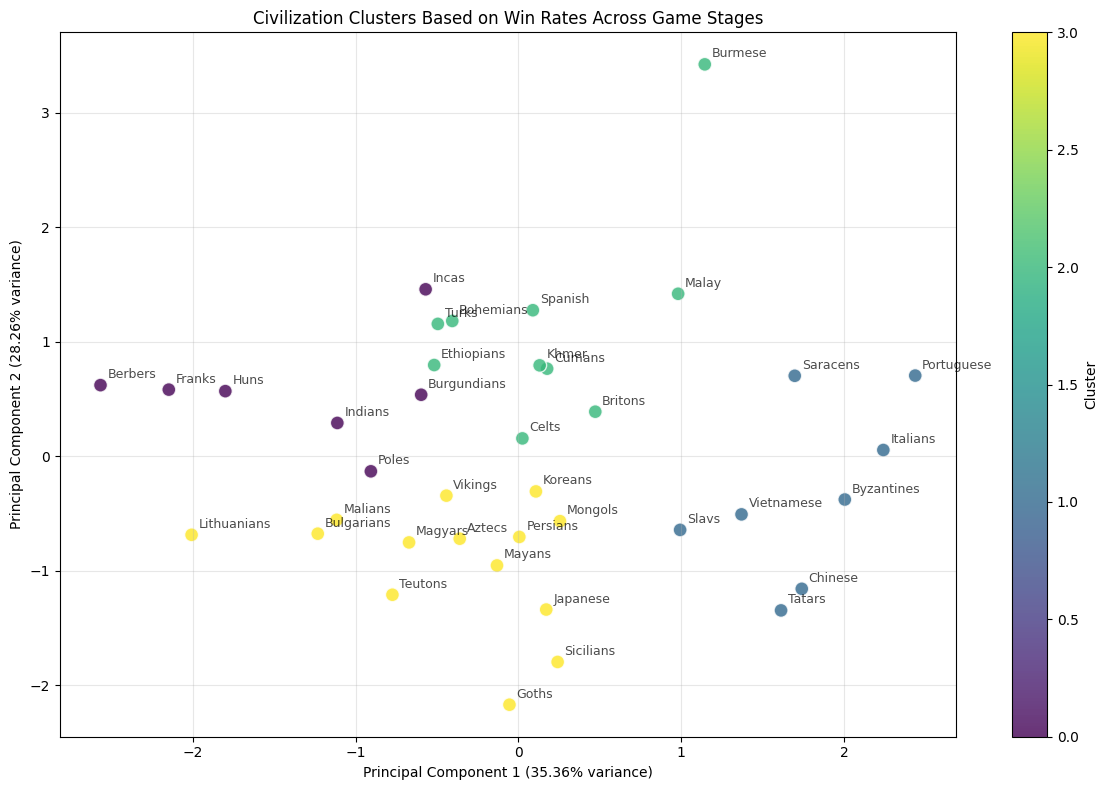

In [29]:
# Use PCA to visualize civilization clusters
from sklearn.decomposition import PCA


# choose the numeric columns you want to cluster
features = heatmap_df.fillna(50)          # or your own df

scaler       = StandardScaler()
scaled_data  = scaler.fit_transform(features)

kmeans   = KMeans(n_clusters=4, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(scaled_data)

pca      = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)


# Apply clustering with the optimal k from your elbow method (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Plot the results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', 
                     s=100, alpha=0.8, edgecolors='w')

# Add labels for each civilization
for i, civ in enumerate(heatmap_df.index):
    plt.annotate(civ, (pca_result[i, 0], pca_result[i, 1]), 
                fontsize=9, alpha=0.7,
                xytext=(5, 5), textcoords='offset points')

plt.title('Civilization Clusters Based on Win Rates Across Game Stages')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization of Civilizations by Cluster

Let's create a 2D visualization of our civilizations to see how they group together and identify any outliers.

## Determining Optimal Number of Clusters

Before finalizing our clusters, we need to determine the optimal number of groups. The elbow method plots the sum of squared distances (inertia) against the number of clusters. The 'elbow' point where the rate of decrease sharply changes indicates a good number of clusters to use.

This helps us avoid both overfitting (too many clusters) and underfitting (too few clusters) in our analysis.

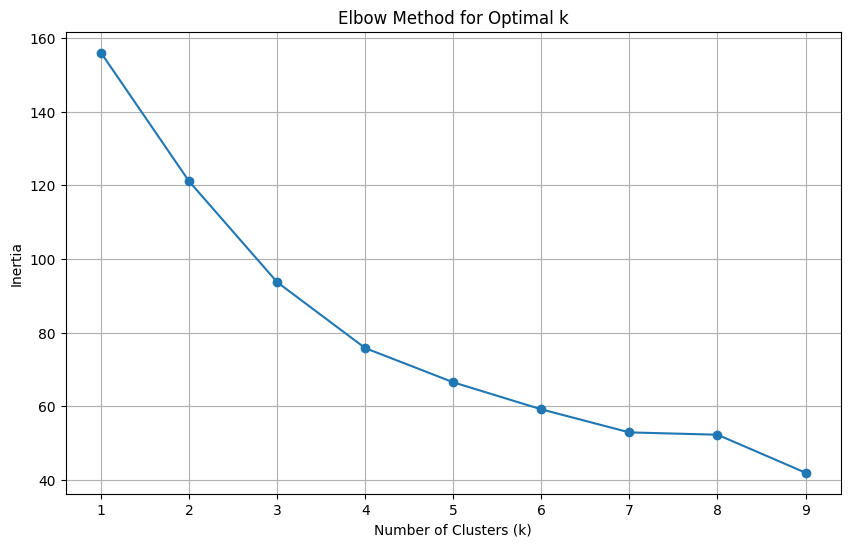

In [30]:
# Scale the data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(heatmap_df.fillna(50))

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

## Cluster Evaluation with Silhouette Score

After analyzing the elbow plot, we evaluate the quality of clusters using the silhouette score, which measures how similar an object is to its own cluster compared to other clusters. Higher silhouette scores indicate better-defined clusters.

The code below evaluates K=3 and K=4 clusters using silhouette scoring and selects the optimal value.

k=3  •  silhouette=0.218
k=4  •  silhouette=0.243

➡  Using k=4 (highest silhouette)

=== Cluster Summary ===
         n_civs  early_avg  mid_avg  late_avg  vlate_avg
cluster                                                 
0             7      26.03    24.86     23.61      25.84
1             8      28.30    28.45     26.98      23.69
2            10      26.14    25.59     27.01      25.86
3            14      24.45    26.08     25.31      23.01

Cluster 0 civs: Berbers, Burgundians, Franks, Huns, Incas, Indians, Poles

Cluster 1 civs: Byzantines, Chinese, Italians, Portuguese, Saracens, Slavs, Tatars, Vietnamese

Cluster 2 civs: Bohemians, Britons, Burmese, Celts, Cumans, Ethiopians, Khmer, Malay, Spanish, Turks

Cluster 3 civs: Aztecs, Bulgarians, Goths, Japanese, Koreans, Lithuanians, Magyars, Malians, Mayans, Mongols, Persians, Sicilians, Teutons, Vikings


<Figure size 1000x500 with 0 Axes>

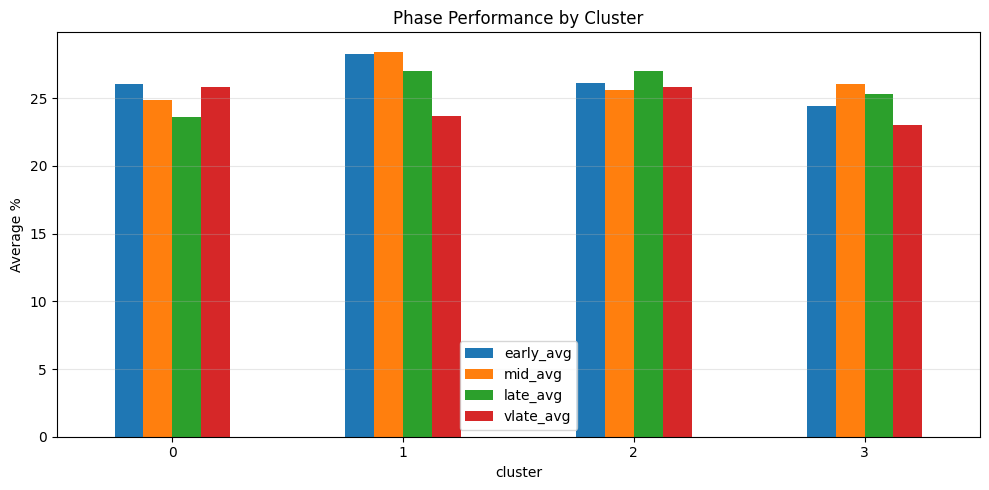

In [31]:

df_heatmap = heatmap_df.copy().fillna(50)       # simple placeholder; tweak if needed
scaled_X   = StandardScaler().fit_transform(df_heatmap)



best_k, best_score = None, -1
for k in [3, 4]:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    lbl = km.fit_predict(scaled_X)
    score = silhouette_score(scaled_X, lbl)
    print(f"k={k}  •  silhouette={score:.3f}")
    if score > best_score:
        best_k, best_score = k, score

print(f"\n➡  Using k={best_k} (highest silhouette)")


# Fit the KMeans model with the best k
kmeans              = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df_heatmap['cluster'] = kmeans.fit_predict(scaled_X)


# Add cluster labels to the original dataframe
df = df_heatmap.reset_index()                   # bring 'civilization' out of index

cluster_stats = (df
                 .groupby('cluster')
                 .agg(
                     n_civs      = ('civilization','count'),
                     early_avg   = ('Early','mean'),
                     mid_avg     = ('Mid','mean'),
                     late_avg    = ('Late','mean'),
                     vlate_avg   = ('Very Late','mean'))
                 .round(2))

print("\n=== Cluster Summary ===")
print(cluster_stats)

# list civs per cluster (optional)
for k in sorted(df['cluster'].unique()):
    civ_list = ", ".join(df.loc[df['cluster']==k, 'civilization'])
    print(f"\nCluster {k} civs: {civ_list}")

# Plot the cluster performance
plt.figure(figsize=(10, 5))
cluster_stats[['early_avg','mid_avg','late_avg','vlate_avg']].plot.bar(
    figsize=(10,5), ylabel='Average %', title='Phase Performance by Cluster', rot=0)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



## Spatial Analysis of Winning Positions

Map positioning plays a crucial role in AOE2 strategy. The heatmap below visualizes where winning civilizations tend to be positioned, helping identify strategic advantages of certain starting locations.

Areas with higher concentration (brighter colors) indicate starting positions that correlate with higher win rates.

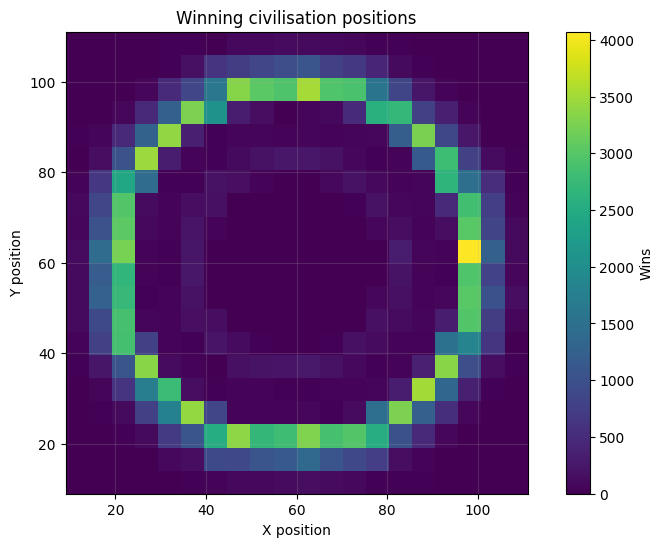

In [32]:
# isolate the winner civs
data['win_x'] = np.where(data['winner'] == 1, data['p1_xpos'], data['p2_xpos'])
data['win_y'] = np.where(data['winner'] == 1, data['p1_ypos'], data['p2_ypos'])

# drop nans
coords = data[['win_x', 'win_y']].dropna()

# ── 2A. simple 2-D histogram (square heat-map) ───────────────────
plt.figure(figsize=(10,6))
plt.hist2d(coords['win_x'], coords['win_y'],
           bins=20, cmap='viridis')        # tweak bins for resolution
plt.colorbar(label='Wins')
plt.title('Winning civilisation positions')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.gca().set_aspect('equal')              # keep it square
plt.grid(alpha=0.2)
plt.show()


## Analyzing Civilization Performance by Distance

The distance between players' starting positions can significantly impact gameplay, favoring certain civilizations over others. This section analyzes how different civilizations perform when spawned at varying distances from opponents.

We calculate the Euclidean distance between starting Town Centers and categorize them into three groups:
- **Close**: Players spawn near each other, favoring rush strategies
- **Medium**: Standard distance between players
- **Far**: Players spawn far apart, favoring boom strategies

The Chi-square test helps identify civilizations whose performance significantly depends on spawn distance.

In [33]:
import scipy.stats as ss


# Euclidean distance between starting TCs
data['spawn_dist'] = np.hypot(data['p1_xpos'] - data['p2_xpos'],
                              data['p1_ypos'] - data['p2_ypos'])

# tercile cut-points
q1, q2 = data['spawn_dist'].quantile([.33, .66])
data['dist_bin'] = pd.cut(data['spawn_dist'],
                          bins=[-np.inf, q1, q2, np.inf],
                          labels=['close', 'medium', 'far'])


results = []
for civ in data['p1_civ'].unique():
    sub = data[data['p1_civ'] == civ]
    ct  = pd.crosstab(sub['dist_bin'], sub['winner'])   # 0 = loss, 1 = win
    if ct.shape == (3, 2):                              # ensure all bins present
        chi2, p, *_ = ss.chi2_contingency(ct)
        results.append({
            'civ'       : civ,
            'p_value'   : p,
            'close_win' : ct.loc['close', 1] / ct.loc['close'].sum(),
            'medium_win': ct.loc['medium',1] / ct.loc['medium'].sum(),
            'far_win'   : ct.loc['far',   1] / ct.loc['far'].sum()
        })

summary = (pd.DataFrame(results)
           .sort_values('p_value')
           .round(3))
print(summary.head(10))   # top civs whose win-rate depends on distance


            civ  p_value  close_win  medium_win  far_win
21     Japanese    0.001      0.483       0.509    0.548
17      Koreans    0.015      0.511       0.558    0.492
24     Saracens    0.018      0.564       0.517    0.572
20        Turks    0.022      0.533       0.529    0.488
4       Berbers    0.025      0.469       0.446    0.495
0       Vikings    0.043      0.486       0.515    0.519
25  Burgundians    0.049      0.539       0.507    0.486
36        Poles    0.093      0.510       0.526    0.475
3        Mayans    0.093      0.525       0.508    0.501
12       Tatars    0.126      0.521       0.540    0.561


## Best and Worst Civilizations by Spawn Distance

This visualization highlights the top-performing and worst-performing civilizations at each spawn distance category. This insight is particularly valuable for players when choosing civilizations based on map size or game mode.

- Green bars represent the top 2 civilizations for each distance category
- Red bars represent the bottom 2 civilizations for each distance category
- The dashed line at 50% represents a balanced win rate

Note how certain civilizations excel at specific distances but perform poorly at others, highlighting the importance of map-specific civilization selection.

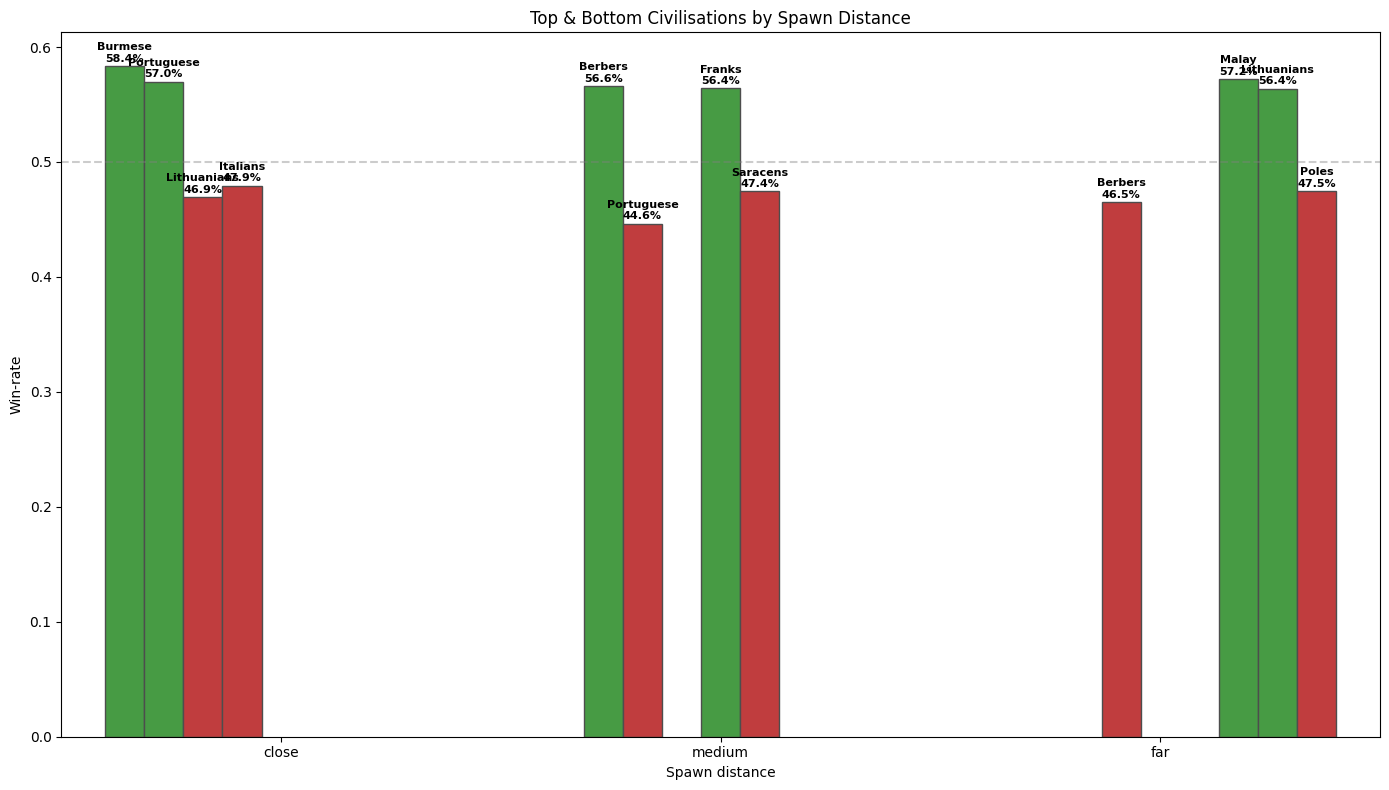

In [44]:
frames = []
for dist in ['close', 'medium', 'far']:
    sub   = data.loc[data['dist_bin'] == dist]
    rates = sub.groupby('p1_civ')['winner'].mean()

    top2  = rates.nlargest(2).reset_index()
    top2['rank'] = 'Best 2'

    low2  = rates.nsmallest(2).reset_index()
    low2['rank'] = 'Worst 2'

    for df in (top2, low2):
        df['dist'] = dist
    frames.extend([top2, low2])

top_bottom = (pd.concat(frames, ignore_index=True)
                .rename(columns={'p1_civ': 'civ',
                                 'winner': 'win_rate'}))



colour_map = {'Best 2': '#3AAA35', 'Worst 2': '#D62728'}
top_bottom['colour'] = top_bottom['rank'].map(colour_map)

# build palette dict keyed by civ so seaborn can use it
palette = top_bottom.set_index('civ')['colour'].to_dict()




plt.figure(figsize=(14,8))
ax = sns.barplot(data=top_bottom,
                 x='dist', y='win_rate',
                 hue='civ', palette=palette,
                 dodge=True, edgecolor='0.3')


# add labels to the bars
for patch, (_, row) in zip(ax.patches, top_bottom.iterrows()):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.text(x, y + 0.002,
            f"{row.civ}\n{y:.1%}",
            ha='center', va='bottom',
            fontsize=8, weight='bold')

# style touches
ax.axhline(0.50, ls='--', c='grey', alpha=.4)
ax.set_ylabel('Win-rate'); ax.set_xlabel('Spawn distance')
ax.set_title('Top & Bottom Civilisations by Spawn Distance')
ax.legend_.remove()          # colours already encode rank
plt.tight_layout(); plt.show()








## Conclusion and Strategic Insights

Our analysis of Age of Empires II match data has revealed several key strategic insights:

1. **Civilization Timing Windows**: Different civilizations have distinct power spikes at different game stages. Players should leverage these timing windows to maximize their chances of winning.

2. **Spawn Distance Effects**: The starting distance between players significantly impacts certain civilizations' performance. This should be considered when choosing civilizations for different map sizes.

3. **Strategic Clustering**: We've identified natural groupings of civilizations with similar performance patterns, helping players understand strategic alternatives when their preferred civilization is banned or countered.

4. **Map Control**: The heatmap analysis shows that certain map positions correlate with higher win rates, highlighting the importance of map control and resource access.

These insights can be applied in competitive play to make more informed civilization picks based on map type, expected game duration, and opponent tendencies.